<div>
<img align="right" src="pictures/Logo.png" width="200"/>
</div>

# Introductory Notebook

# Data filtration and quantum topological algorithm

Kathrin König (kathrin.koenig@iaf.fraunhofer.de), Andreas Woitzik (andreas.woitzik@physik.uni-freiburg.de), Eric Brunner (eric.brunner@physik.uni-freiburg.de)

In [2]:
import numpy as np
import qtda_module as qtda
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from qiskit import ClassicalRegister, transpile
from qiskit_aer import Aer

In this notebook we explain the persistent topological analysis, in particular how topological spectra can be obtained on different scales from a data filtration and how to extract Betti-numbers from them. For this the data cloud is described via a filtration of simplicial complexes, encoding topological and geometric features of the data on different filtration scales.

## Data filtration

Consider a finite set of data points in some metric space, and balls of radius $\varepsilon$ centered at each point. If another point is in the $\varepsilon$-ball of some point, draw a line (a 1-simplex) connecting both points, for any three points in one of the $\varepsilon$-balls draw a (filled) triangle (a 2-simplex) connecting all three points, and so on. The resulting combinatorial object is a collection of $k$-simplices of different orders $k$ and is called a **simplicial complex**.

<div>
<img src="pictures/PointCloud_small-eps.png" width="300"/>
</div>

The topology of the simplicial complex is determined by the number of holes in different dimensions: connected components (0-dimensional holes + 1), 1-dimensional holes, voids (2-dimensional holes), and so on. These numbers are called **Betti-numbers** $\beta_k$.

Constructing such a simplical complex of each radius $\varepsilon$ (respectively a finite set of radii), leads to a **filtration of simplicial complexes** describing the shape of the data points on different filtration scales $\varepsilon$.

<div>
<img src="pictures/PointCloud_big-eps.png" width="200"/>
</div>

A topological feature (e.g. the upper right 1-hole) that *persist* over a large range of $\varepsilon$ is often regarded as topological significant, while short-lived features typically are assumed to be topological noise. However, also such short-lived topological features can encode important information about the geometry of the data (https://arxiv.org/abs/1905.13196).

The *persistence* of the topological features on different topological orders can be summarized by means of a **persistence diagram**, where the birth and death of each feature plotted on the x-, respectively y-axis:

/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/.venv/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:134: UserWarning: usetex mode requires dvipng.
  warnings.warn("usetex mode requires dvipng.")


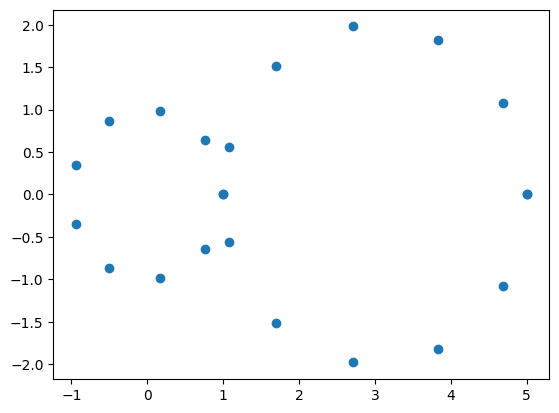

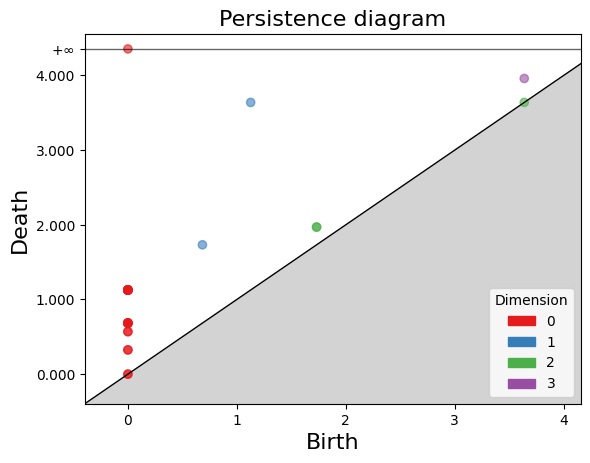

In [3]:
def generate_circles():
    phi_values = np.linspace(0, 2*np.pi, 10)
    small_circle = [[np.cos(phi), np.sin(phi)] for phi in phi_values]
    phi_values = np.linspace(0, 2*np.pi, 12)
    large_circle = [[3 + 2*np.cos(phi), 2*np.sin(phi)] for phi in phi_values]
    
    return np.array(small_circle + large_circle)
    
point_data = generate_circles()
plt.scatter(point_data[:,0], point_data[:,1])

# alternatively a distance matrix (here generated from the point data for exemplification)
# can be used
dist_mat = distance_matrix(point_data, point_data)

filtration = qtda.DataFiltration(
    data=point_data, 
#     distance_matrix=dist_mat, 
    max_dimension=4, 
    max_edge_length=10
    )

filtration.plot_persistence_diagram()

The red points indicate topological features at zeroth dimension, i.e. connected components. At $\varepsilon = 0$, 22 connected components are born, which connect to each others the larger the filtration scale becomes. In the end, only one connected component (all vertices are connected) survives.

The blue points represent the holes in the two circles on dimension one. The smaller circle is born earlier (at scale $\varepsilon \approx 0.7$) then the larger circle ($\varepsilon \approx 1.2$), since the surrounding points of the smaller circle are closer to each other and, therefore, they get connected at an earlier filtration scale. However, the smaller circle dies already at $\varepsilon \approx 1.8$, because at this scale the inner of the circle get filled by 2-simplices generated from three distant points in the small circle. The larger circle is only filled with 2-simplices at scale $\varepsilon \approx 4$, up to which the inner hole persists.

The persistence diagram also shows signatures of higher order topologocial features, which are, however, persist only over short intervals.

## Quantum algorithm for the topological analysis

The extraction of topological features builds on the famous quantum phase estimation (QPE) algorithm. As can be derived from discrete Hodge theory (https://arxiv.org/pdf/1105.2712.pdf), the $k$th Betti-number $\beta_k$ is equal to the dimension of the kernel (respectively of the 0-eigenspace) of the **combinatorial Laplacian** $\Delta_k$, which describes diffusion of information inscibed on simplices of order $k$ through the simplicial complex (https://arxiv.org/pdf/1105.2712.pdf):
$$
\beta_k = \dim \ker \Delta_k = \dim \text{Eig}_0 \Delta_k \,.
$$

The combinatorial Laplacian $\Delta_k$ is a hermitian $n$-qubit operator ($2^n \times 2^n$-matrix), hence its exponential $exp(i\Delta_k)$ is unitary and we can find its eigenvalue-decomposition by means of the QPE algorithm.

The QPE algorithm is based on the `Qiskit` library and explained in detail in https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html. The circuit is illustrated below (picture from Qiskit Textbook). We designed a slightly different implementation of the QPE as provided by `qiskit.circuit.library.PhaseEstimation`, which has a smaller circuit depth. A small circuit depth is especially important if one wants to run the algorithm on real quantum hardware. 

<div>
<img src="pictures/qiskit_QPE.png" width="600"/>
</div>

### Encoding simplices on qubits

We encode an arbitrary simplicial complex $S$, i.e. all its contained simplices on all orders, on $n$ vertices by means of $n$ qubits. This already provides an exponential memory advantage over classical algorithms, in which all simplices (the number of these grows exponentially with $n$) have to be stored on individual bit-strings.

Let $\lbrace s_k^i \rbrace_i$ be the set of $k$-simplices contained in the complex $S$. Each $s_k^i$ is encoded by a $n$-qubit state $\left| s_k^i \right\rangle = \left| 0,1,1,0,1,0,...,0 \right\rangle$ of $n$ qubits with exactly $k+1$ ones, describing the $k+1$ vertices that are included in the $k$-simplex. We enumerate the vertices from the right and start counting at zero, i.e. $[0,\dots,0,1]$ is the zeroth vertex, $[0,\dots,0,1,0]$ is the first vertex and $[0,\dots0,1,0,1]$ is a edge connecting the zeroth and the second vertex. The projector $\rho_k$ onto all $k$-simplices in $S$ is given by
$$
\rho_k = \frac{1}{|\lbrace s_k^i \rbrace_i |} \sum_{s_k^i \in S} \left| s_k^i \right\rangle \left\langle s_k^i \right| \,,
$$
and is feeded as input state into the phase estimation algorithm.

The uniform superposition $\left| \psi_k \right\rangle= \sum_{s_k^i \in S} \left| s_k^i \right\rangle$ can be constructed by Grover's search algorithm by employing a classical oracle, deciding wheter a state $\left| 0,1,1,0,1,0,...,0 \right\rangle$ is included in the complex $S$. From this superposition $\rho_k$ can be easily obtained by employing a copy-register on which we copy the state-qubits, which afterwards is traced out. In our work, because of the limited time horizon, the input state $\left| \psi_k \right\rangle$ is directly initialized using the Qiskit library.

### The circuit

For a convenient application, the implementation `qtda.QTDAalgorithm` of the quantum algorithm for the analysis of persistent topological features is directly integrated in Qiskti as as a subclass of the `qiskit.QuantumCircuit` class.

As an example, the quantum circuit for the topological analysis of an example simplicial complex of four abstract points is drawn. The complex is shown below. It is build from four 0-simplices (vertices)
$$
S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)] \,,
$$
five 1-simplices (edges)
$$
S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)] \,,
$$
and one 2-simplex (triangle)
$$
S2 = [(1,0,1,1)] \,.
$$
The simplicial complex has a single 1-dimensional hole, i.e. the absence of the 1-simplex $[1,1,1,0]$ connecting vertices 1,2 and 3. To detect this hole, the algorithm has to determine the dimension of the 0-Eigenspace of the combinatorial Laplacian $\Delta_k$ on first order $k=1$.


<div>
<img src="pictures/sample_simpl_complex.png" width="250"/>
</div>

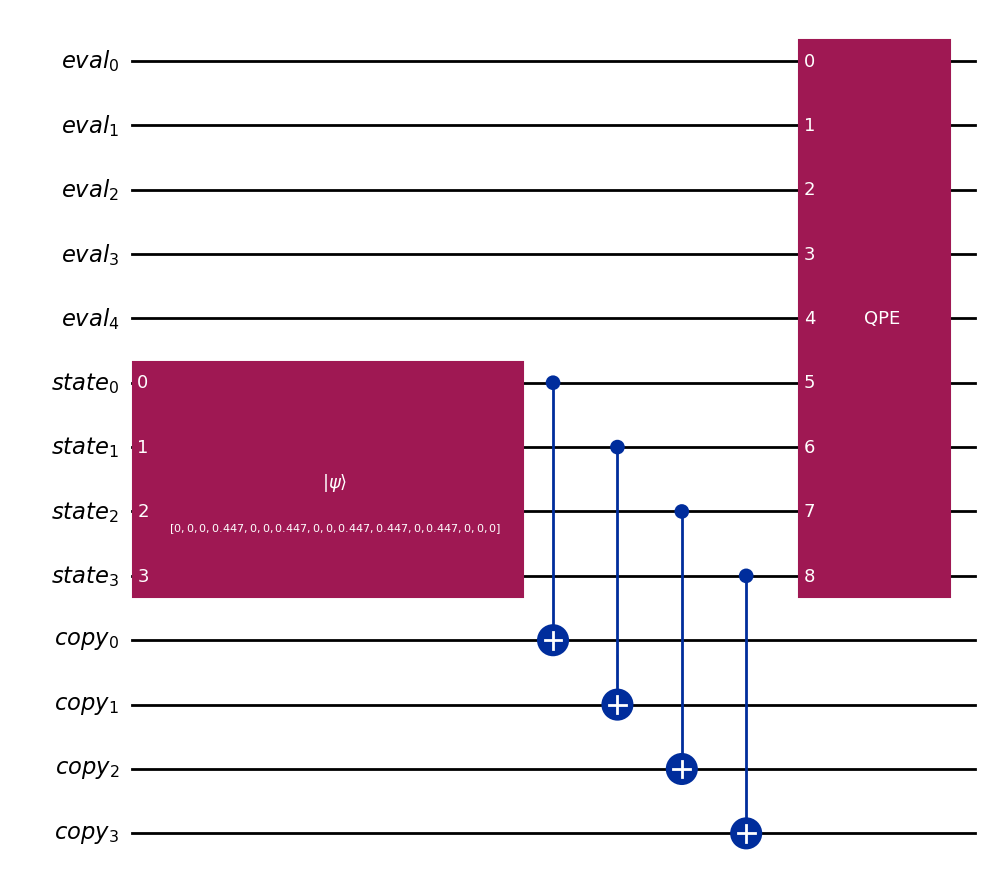

In [4]:
n_vertices = 4 # number of qubits to represent the simplicial complex
num_eval_qubits = 5 # number of numerical evaluation qubits for the QPE algorithm

S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)] # 0-simplex: points in the graph
S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)] # 1-simplex: connection lines between points
S2 = [(1,0,1,1)] # 2-simplex: filled triangle
S3 = []

state_dict = {0: S0, 1: S1, 2: S2, 3: S3}
k = 1 # order of the combinatorial Laplacian
qc = qtda.QTDAalgorithm(num_eval_qubits, k, state_dict)
qc.draw('mpl')

Employing $\rho_k$ as input state for the QPE algorithm, we see that the dimension of the eigenspace to eigenvalue $\omega$ is proportional to the probability of measuring the phase $\varphi = \frac{\omega}{2\pi}$ at the output of the phase estimation protocol:

$$
\dim \text{Eig}_\omega \Delta_k = | \lbrace s_k^i \rbrace_i | \; \text{Prob} \left( \frac{\omega}{2\pi} \right)
$$

In our example we have five 1-simplices, hence, the first Betti-number $\beta_1$, i.e. the number of 1-holes, is given by 

$$
\beta_1 = \dim \text{Eig}_0 \Delta_1 = 5 \; \text{Prob} \left( \frac{0}{2\pi} \right)
$$

We estimate $\beta_1$ from the output counting statics, by adding measurements on the evaluation qubits (listed in `qc.eval_qubits`).

In [5]:
qc.add_register(ClassicalRegister(num_eval_qubits)) #add classical register to measure evaluation qubits
for q in qc.eval_qubits:
    qc.measure(q,q)

shots = 1000
backend = Aer.get_backend('qasm_simulator')
# job = execute(qc, backend, shots=shots)
new_circuit = transpile(qc, backend)
job = backend.run(new_circuit)
counts = job.result().get_counts(new_circuit)

The number of 1-holes is 1.12


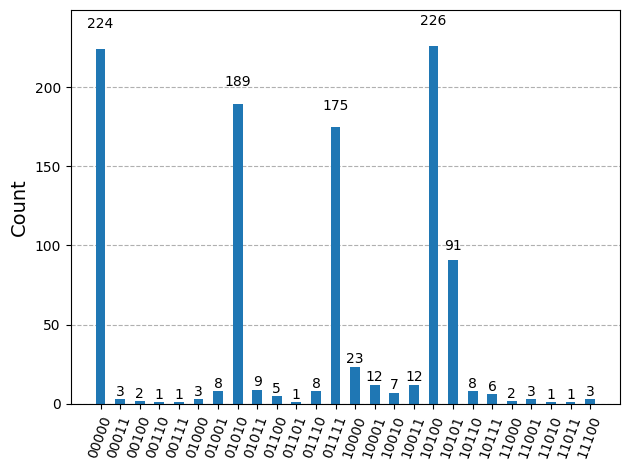

In [6]:
dim = len(state_dict[1])  # dimension of 1-simplex space
prob = (counts.get("0"*num_eval_qubits, 0) or 0) / shots  # probability of eigenvalue 0

print('The number of 1-holes is', dim * prob)
plot_histogram(counts)

..., i.e. approximately $\beta_1 = 1$, in line of what we would expect from the picture of the simplicial complex.

## Analysis of the topological spectra

The algorithm actually allows us to extract further geometric information from the simplical complex, which is encoded in all the eigenvalues of $\Delta_k$ on all orders $k=1,2,3$. To obtain the full topological spectra with the dimensions of the corresponding eigenspaces, we call `qtda.Q_top_spectra` and extract the topological spectra. Note that to obtain reliable estimates for all eigenvalues, a larger numerical precision (`num_eval_qubits`) of the phase estimation algorithm is necessary. This we set to 10.

In [7]:
shots = 1000
num_eval_qubits = 10

data = qtda.Q_top_spectra(state_dict, num_eval_qubits, shots)
spectra = data.get_spectra()

Topological order:  0
Topological order:  1
Topological order:  2
Topological order:  3
calculation terminated because no simplex of dimension 3



Topological order:  0
Number of holes:  0
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 4.00453257114476: np.float64(3.032), 2.00226628557238: np.float64(0.952)}


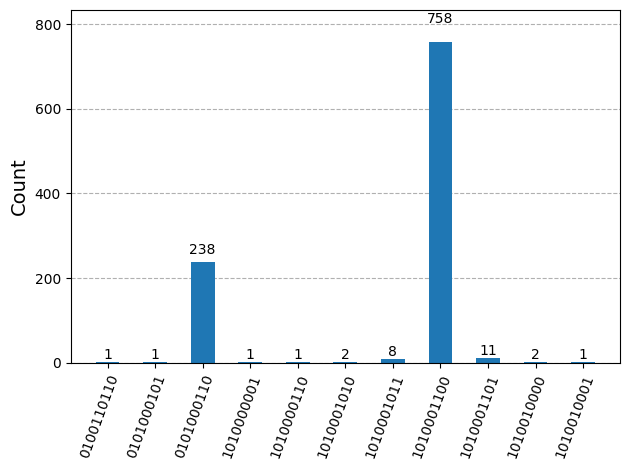


Topological order:  1
Number of holes:  1.11
Dimension of the k-simplex subspace:  5
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: np.float64(1.11), 3.0033994283585703: np.float64(1.01), 4.00453257114476: np.float64(1.785), 2.00226628557238: np.float64(1.11)}


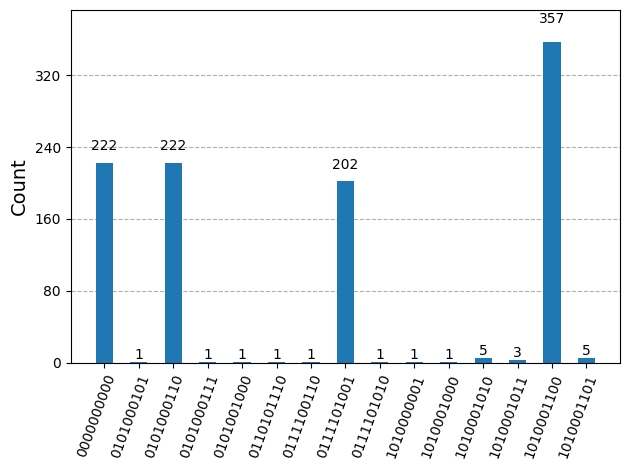


Topological order:  2
Number of holes:  0
Dimension of the k-simplex subspace:  1
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 3.0033994283585703: np.float64(1.003)}


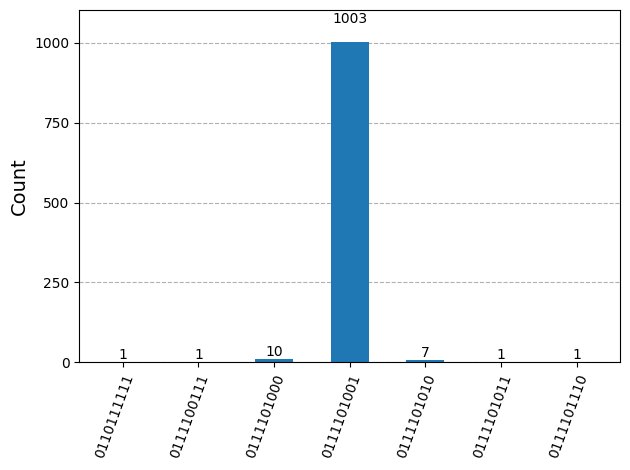

In [8]:
for top_order in spectra.keys():
    print()
    print('Topological order: ', top_order)
    print('Number of holes: ', spectra[top_order][0.0])
    print('Dimension of the k-simplex subspace: ', len(data.state_dict[top_order]))
    print('Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: ')
    print(spectra[top_order])
    display(plot_histogram(data.get_counts()[top_order]))

Only eigenvalues are considered with at least 2% probability, all others are considered as noise. The chop-value (minimum number of counts) can be set in the `get_spectra(chop=..)` method. We see that the dimensions of the eigenspaces sum up approximately to the dimension of the k-simplex space. This verifies that the algorithm, indeed, discovers all eigen-spaces of $\Delta_k$ on the $k$-simplex subspaces.

## Comparing to an alternative simplicial complex

The above analysis can be compared to the simplicial complex, where both triangular 2-simplices are missing, i.e. where we have two 1-dimensional holes. For this we have to consider the same complex but with no 2-simplices $S2 = []$, instead.

<div>
<img src="pictures/sample_simpl_comp_empt.png" width="250"/>
</div>

In [9]:
n_vertices = 4

S0 = [(0,0,0,1),(0,0,1,0), (0,1,0,0),(1,0,0,0)]
S1 = [(0,0,1,1),(0,1,1,0),(1,1,0,0),(1,0,0,1),(1,0,1,0)]
S2 = []
S3 = []

state_dict = {0: S0, 1: S1, 2: S2, 3: S3}

shots = 1000
num_eval_qubits = 10

data = qtda.Q_top_spectra(state_dict, num_eval_qubits, shots)
spectra = data.get_spectra()

Topological order:  0
Topological order:  1
Topological order:  2
calculation terminated because no simplex of dimension 2



Topological order:  0
Number of holes:  0
Dimension of the k-simplex subspace:  4
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: 0, 2.00226628557238: np.float64(1.004), 4.00453257114476: np.float64(2.948)}


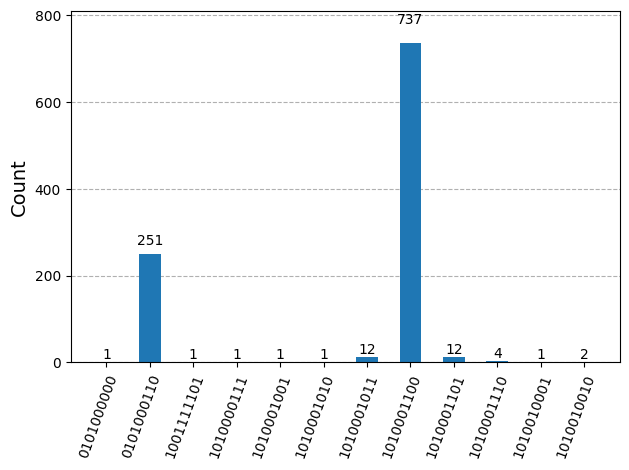


Topological order:  1
Number of holes:  2.1
Dimension of the k-simplex subspace:  5
Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: 
{0.0: np.float64(2.1), 2.00226628557238: np.float64(0.99), 4.00453257114476: np.float64(1.965)}


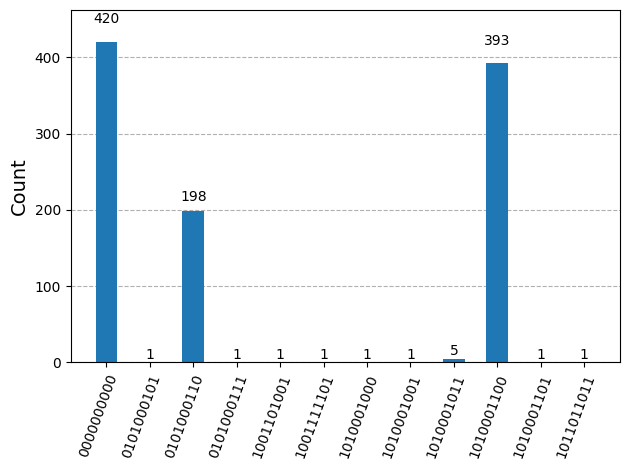

In [10]:
for top_order in spectra.keys():
    print()
    print('Topological order: ', top_order)
    print('Number of holes: ', spectra[top_order][0.0])
    print('Dimension of the k-simplex subspace: ', len(data.state_dict[top_order]))
    print('Eigenvalues of the combinatorial laplacian with dimension of corresponding eigenspaces: ')
    print(spectra[top_order])
    display(plot_histogram(data.get_counts()[top_order]))

Comparing to the simplicial complex with one filled triangle, we see that on zeroth order both complexes look exactly the same in terms of their topological spectra (up to noise). However, on first order we see that for the two 1-dimensional holes in the two empty triangles of the second complex are correctly identified. Also the topological spectrum at order $k=1$ is different to the case of the first simplicial complex with only one empty triangle. In this case we have a one-dimensional eigenspace of $\Delta_1$ corresponding to the eigenvalue $\sim 3$.

## Persistent analysis

Above we only considered the topological analysis of fixed example of small simplicial complexes. To analyse topological features of data clouds on different scales, we have to combine this with the data filtration procedure, explained in the beginning of this notebook. This is done in the Jupyter-notebook `quantum_persistent_top_spectra.ipynb`, which can be found in https://github.com/KathrinKoenig/QuantumTopologicalDataAnalysis.

In [11]:
import qiskit
qiskit.__qiskit_version__

AttributeError: module 'qiskit' has no attribute '__qiskit_version__'